In [1]:
from scipy.io import loadmat
import numpy as np

In [2]:
data = loadmat("./datasets/MNISTmini.mat")

print(data.keys())
train_fea = data['train_fea1']
train_gnd = data['train_gnd1']
test_fea = data['test_fea1']
test_gnd = data['test_gnd1']

#print(np.shape(train_fea)) # (60000, 100)
#print(np.shape(train_gnd)) # (60000, 1)
#print(np.shape(test_fea)) # (10000, 100)
#print(np.shape(test_gnd)) # (10000, 1)

dict_keys(['__header__', '__version__', '__globals__', 'train_fea1', 'train_gnd1', 'test_fea1', 'test_gnd1'])


In [3]:
# insert labels as last column of feature matrix
train_samples = np.column_stack((train_fea, train_gnd)) 

#print(train_samples)
#print(train_samples.shape)

In [4]:
from sklearn.utils import resample

# sample (w/o replacement) 3000 samples from train_samples
sub_samples = resample(train_samples, replace=False, n_samples=3000, random_state=20)

# print(np.unique(sub_samples[:,-1])) # 10 total classes: 0-9, so to classify image as digit-0 -> class 1

sub_train_fea = sub_samples[0:1000, :100] # features
sub_train_gnd = sub_samples[0:1000, -1] # labels

sub_val_fea = sub_samples[1000:2000, :100]
sub_val_gnd = sub_samples[1000:2000, -1]

sub_test_fea = sub_samples[2000:3000, :100]
sub_test_gnd = sub_samples[2000:3000, -1]

# digit-5 samples:
full_sample_digit_5 = sub_samples[2000:3000][sub_samples[2000:3000, -1] == 6] # digit-5 = class 6
test_digit_5_fea = full_sample_digit_5[:50,:100]
test_digit_5_gnd = full_sample_digit_5[:50, 100]

#print("Full test sample matrix containing label for digit-5:\n", full_sample_digit_5)
#print("Test sample features:\n", test_digit_5_fea) # 86/1000 total rows
#print("Test sample labels:\n", test_digit_5_gnd) # 86/1000 rows are labeled as digit 5

# digit-8 samples:
full_sample_digit_8 = sub_samples[2000:3000][sub_samples[2000:3000, -1] == 9] # digit-8 = class 9
test_digit_8_fea = full_sample_digit_8[:50, :100]
test_digit_8_gnd = full_sample_digit_8[:50, 100]

#print("Full sample matrix containing label for digit-8:\n", full_sample_digit_8)
#print("Test sample features:\n", len(test_digit_8_fea)) # 115/1000 total rows 
#print("Test sample labels\n", len(test_digit_8_gnd)) # 115/1000 rows are labeled as digit 8


In [5]:
# Logistic Classifier:

# Task: 
#   - Binary classification (digit-5 vs. digit-8)

# Suggestions:
#   - Use L2 regularization w/ hyperparameter determined via cross-validation
#   - Use 'linlinear' training algorithm (solver)

In [6]:
# Train/Validation/Test Split: 33/33/33:

# Training set
X_train = sub_train_fea
y_train = sub_train_gnd

# Validation set
X_val = sub_val_fea
y_val = sub_val_gnd

# Test set (multi-class)
X_test = sub_test_fea
y_test = sub_test_gnd

#print(X_test)
#print(y_test)

# Test set (digit-5/class 6)
X_test_digit_5 = test_digit_5_fea
y_test_digit_5 = test_digit_5_gnd

# Test set (digit-8/class 9)
X_test_digit_8 = test_digit_8_fea
y_test_digit_8 = test_digit_8_gnd


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier  
from sklearn.multiclass import OneVsRestClassifier

import time

In [8]:
# Check class distribution to determine if classes are balanced/imbalanced
classes, counts = np.unique(y_train, return_counts=True)

for cls, count in zip(classes, counts):
    print(f'Class {cls}: {count} samples')

print()

# Proportions for each class
proportions = counts/len(y_train)
for cls, prop in zip(classes, proportions):
    print(f'Class {cls}: {prop*100:.2f}%')

Class 1: 106 samples
Class 2: 102 samples
Class 3: 107 samples
Class 4: 101 samples
Class 5: 87 samples
Class 6: 95 samples
Class 7: 96 samples
Class 8: 101 samples
Class 9: 105 samples
Class 10: 100 samples

Class 1: 10.60%
Class 2: 10.20%
Class 3: 10.70%
Class 4: 10.10%
Class 5: 8.70%
Class 6: 9.50%
Class 7: 9.60%
Class 8: 10.10%
Class 9: 10.50%
Class 10: 10.00%


In [9]:
start = time.time()
# One-vs-rest classifier with logistic regression as base estimator
ovr_clf = OneVsRestClassifier(
    LogisticRegression(
        # liblinear implements a trust region newton method
        # n_jobs = 1 (1 core, no parallelism)
        penalty='l2', solver='liblinear', max_iter=300, random_state=20, verbose=0
    )
    ).fit(X_train, y_train) # train classifier on multi-class training samples (1000 samples)
stop = time.time()

train_time = stop - start

print(f"Training time (OvR) (1000 training samples): {train_time:.3f}s")

#ovr_clf.predict(X_test) # test on multi-class samples from test set
#ovr_clf_score = ovr_clf.score(X_test, y_test)
#print(ovr_clf_score)

start = time.time()
ovr_clf.predict(X_test_digit_5) # test classifier on digit-5 samples only from test set (50 samples)
ovr_clf.predict(X_test_digit_8) # test classifier on digit-8 samples only from test set (50 samples)
end = time.time()

inference_time = end - start

print(f'Inference time (OvR) (100 total test samples): {inference_time:.5f}s')

ovr_clf_score_5 = ovr_clf.score(X_test_digit_5, y_test_digit_5)
ovr_clf_score_8 = ovr_clf.score(X_test_digit_8, y_test_digit_8)

# Score for digit-5, digit-8 classification over test set w/ one-vs-all classifier
print(f"digit-5 (50 test samples): {ovr_clf_score_5:.3f}")
print(f"digit-8 (50 test samples): {ovr_clf_score_8:.3f}")

Training time (OvR) (1000 training samples): 0.588s
Inference time (OvR) (100 total test samples): 0.00000s
digit-5 (50 test samples): 0.860
digit-8 (50 test samples): 0.660


In [10]:
start = time.time()
# One-vs-one classifier with logistic regression as base estimator
ovo_clf = OneVsOneClassifier(
        LogisticRegression(
            penalty='l2', solver='liblinear', max_iter=300, random_state=20, verbose=0
        )
    ).fit(X_train, y_train)
stop = time.time()

train_time = stop - start

print(f"Training time (OvO) (1000 training samples): {train_time:.3f}s")

start = time.time()
ovo_clf.predict(X_test_digit_5) # test classifier on digit-5 samples only from test set (50 samples)
ovo_clf.predict(X_test_digit_8) # test classifier on digit-8 samples only from test set (50 samples)
end = time.time()

inference_time = end - start

print(f'Inference time (OvO) (100 total test samples): {inference_time:.5f}s')

ovo_clf_score_5 = ovo_clf.score(X_test_digit_5, y_test_digit_5)
ovo_clf_score_8 = ovo_clf.score(X_test_digit_8, y_test_digit_8)

# Score for digit-5, digit-8 classification w/ one-vs-one classifier
print(f"digit-5 (50 test samples): {ovo_clf_score_5:.3f}")
print(f"digit-8 (50 test samples): {ovo_clf_score_8:.3f}")

#ovo_clf.predict(X_test) # test on multi-class samples
#ovo_clf_score = ovo_clf.score(X_test, y_test)
#print(ovo_clf_score)

Training time (OvO) (1000 training samples): 0.120s
Inference time (OvO) (100 total test samples): 0.01776s
digit-5 (50 test samples): 0.960
digit-8 (50 test samples): 0.820


In [11]:
# Things to explore: 
# (1) Why the classifier performs better on digit-5 compared to digit-8.
# (2) Why the one-vs-one classifier performs slower during testing compared to one-vs-all? Probably due to the difference in the sample dimentions.
# (3) Track the training and inference time for both types of classifiers.
# (4) Use cross-validation to optimize the regularization hyperparameter.
# (5) Plot validation vs training error

In [18]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

start = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
stop = time.time()

train_time = stop - start

print(f"Training time (OvR) (1000 training samples): {train_time:.3f}s")

#ovr_clf.predict(X_test) # test on multi-class samples from test set
#ovr_clf_score = ovr_clf.score(X_test, y_test)
#print(ovr_clf_score)

start = time.time()
rf_model.predict(X_test_digit_5) # test classifier on digit-5 samples only from test set (50 samples)
rf_model.predict(X_test_digit_8) # test classifier on digit-8 samples only from test set (50 samples)
end = time.time()

inference_time = end - start

print(f'Inference time (OvR) (100 total test samples): {inference_time:.5f}s')

rfc_score_5 = rf_model.score(X_test_digit_5, y_test_digit_5)
rfc_score_8 = rf_model.score(X_test_digit_8, y_test_digit_8)

# Score for digit-5, digit-8 classification over test set w/ one-vs-all classifier
print(f"digit-5 (50 test samples): {rfc_score_5:.3f}")
print(f"digit-8 (50 test samples): {rfc_score_8:.3f}")

Training time (OvR) (1000 training samples): 0.442s
Inference time (OvR) (100 total test samples): 0.00000s
digit-5 (50 test samples): 0.980
digit-8 (50 test samples): 0.900


In [ ]:
# Cross Validation using Validation set

from sklearn.model_selection import cross_val_score

ovo_clf_score = cross_val_score(ovo_clf, X_train, y_train, cv=3) # 3 folds since 1000 samples only
ovr_clf_score = cross_val_score(ovr_clf, X_train, y_train, cv=3) 
random_forest_score = cross_val_score(rf_model, X_train, y_train, cv=3) 

print(f"OVO CV Score: {ovo_clf_score}, mean: {ovo_clf_score.mean():.2f}")
print(f"OVR CV Score: {ovr_clf_score.}, mean: {ovr_clf_score.mean():.2f}")
print(f"RF CV Score: {random_forest_score}, mean: {random_forest_score.mean():.2f}")

OVO CV Score: [0.82035928 0.83783784 0.85585586], mean: 0.84
OVR CV Score: [0.75748503 0.73873874 0.77777778], mean: 0.76
RF CV Score: [0.8502994  0.84984985 0.84084084], mean: 0.85


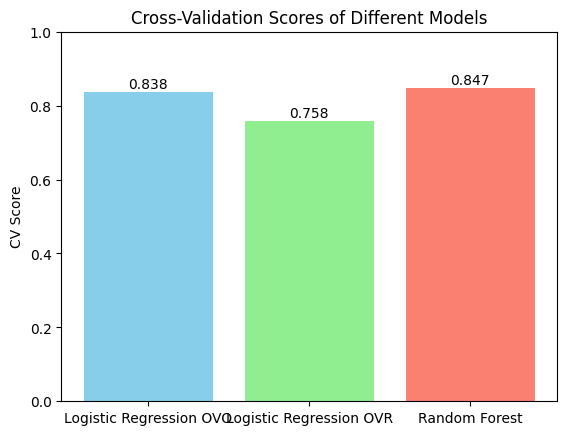

In [ ]:
import matplotlib.pyplot as plt

model_names = ['Logistic Regression OVO', 'Logistic Regression OVR', 'Random Forest']
scores = [ovo_clf_score, ovr_clf_score, random_forest_score]
mean_scores = [ovo_clf_score.mean(), ovr_clf_score.mean(), random_forest_score.mean()]

bars = plt.bar(model_names, mean_scores, color=['skyblue', 'lightgreen', 'salmon'])

for bar, score in zip(bars, mean_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.3f}', 
             ha='center')

plt.ylabel('CV Score')
plt.title('Cross-Validation Scores of Different Models')
plt.ylim(0, 1)
plt.show()



In [ ]:
# Tuning hyperparamters for Random Forest model using Grid Search CV

from sklearn.model_selection import GridSearchCV

# Hyperparameters to test
param_grid = {
    'n_estimators': [50,100,150,200],
    'max_depth': [None, 5, 10,15,20]
}

grid_search_cv = GridSearchCV(rf_model, param_grid=param_grid, cv=3) #searches model with best hyperparameters from combination

grid_search_cv.fit(X_train,y_train)
best_rf_model = grid_search_cv.best_estimator_ # Best Random Forest Model
print(f"Chosen Hyperparameters: {grid_search_cv.best_params_}")

Chosen Hyperparameters: {'max_depth': None, 'n_estimators': 300}


In [41]:
# Validation Score on the best random Forest Model

validation_score = best_rf_model.score(X_val,y_val)
print(f"Validation Accuracy: {validation_score}")

Validation Accuracy: 0.873
